# "Extract Model Verification Data"
including:
- N
- Si
- PON -> Detritus!
- P
    - Diatoms
    - Nanos
    - Coccos
    - Dinos
- Z (use ncdf file! data cleaned up alrdy (but perhaps missing a few data...)
    - 200 - 500 µm
    - 500 - 1000 µm

In [211]:
require(tidyverse, warn.conflicts = FALSE)
require(cowplot, warn.conflicts = FALSE)
require(scales, warn.conflicts = FALSE)

require(oce, warn.conflicts = FALSE)

## interpolation depth

In [212]:
zz <- seq(0, 100, 1)

# get MLD depth

In [213]:
# read MLD and euphotic depth file
MLD2EuZ <- read.csv("DATA_processed/MLD2EuZ.csv")

# read Date column
MLD2EuZ$Date <- as.Date(MLD2EuZ$Date, format="%Y-%m-%d")

# GET SILICATE

In [214]:
#Niskin
niskin <- read.csv("DATA_processed/Niskin_bottle_processed.csv")
niskin$Date <- as.Date(niskin$Date, format="%Y-%m-%d")

In [215]:
SiOH <- niskin %>%
  select(Date, SiOH4, Depth_real) %>%
  gather(key='key',value = "value", -Date, -Depth_real)
head(SiOH)

Date,Depth_real,key,value
1995-11-08,1.5,SiOH4,NA
1995-11-08,6.5,SiOH4,NA
1995-11-08,15.0,SiOH4,NA
1995-11-08,25.0,SiOH4,NA
1995-11-08,35.0,SiOH4,NA
1995-11-08,54.5,SiOH4,NA


In [216]:
SiOH_int <- SiOH %>%
    group_by(Date) %>%
    do(data.frame(value_int = with(.,oceApprox(Depth_real, value, zz, "rr")), depth = zz)) 

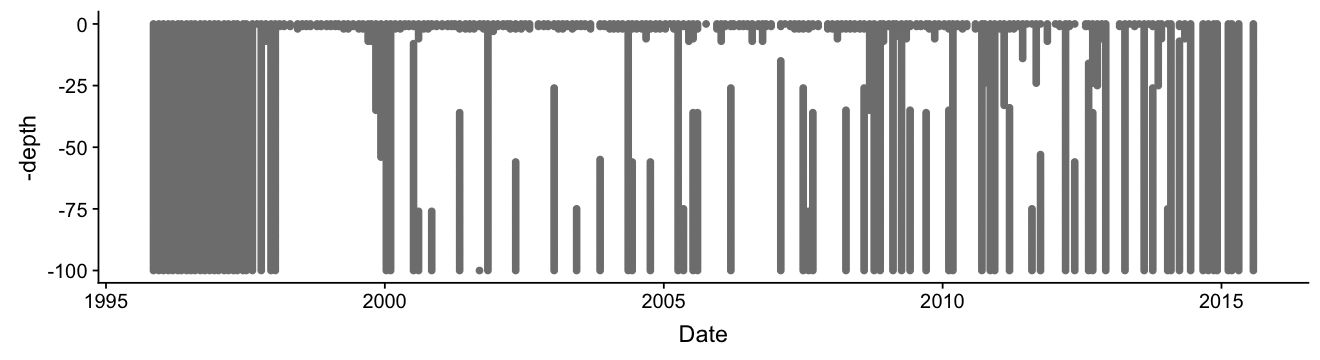

In [217]:
options(repr.plot.width=11, repr.plot.height=3)
ggplot(SiOH_int[is.na(SiOH_int$value_int),], aes(x=Date,y=-depth,col=value_int))+geom_point()

In [218]:
merge_SiOH_mld <- merge(SiOH_int, MLD2EuZ, by="Date")

merge_SiOH_mld$depthdiff <- merge_SiOH_mld$MLD2015 - merge_SiOH_mld$depth

In [219]:
SiOH_above_mld <- merge_SiOH_mld %>%
  group_by(Date) %>% # this groups it by the run number 
  filter(depthdiff > 0) %>% # only keep values above MLD
  summarize(SiOH=mean(value_int, na.rm=T))

head(SiOH_above_mld)
#niskin_at_mld_filtered <- niskin_at_mld[niskin_at_mld$depthdiff>-15,] # only take values up to 17 meters below MLD

Date,SiOH
1996-01-12,NaN
1996-02-13,NaN
1996-03-13,NaN
1996-04-16,NaN
1996-05-09,NaN
1996-06-12,NaN


Warning message:
“Removed 45 rows containing missing values (geom_point).”

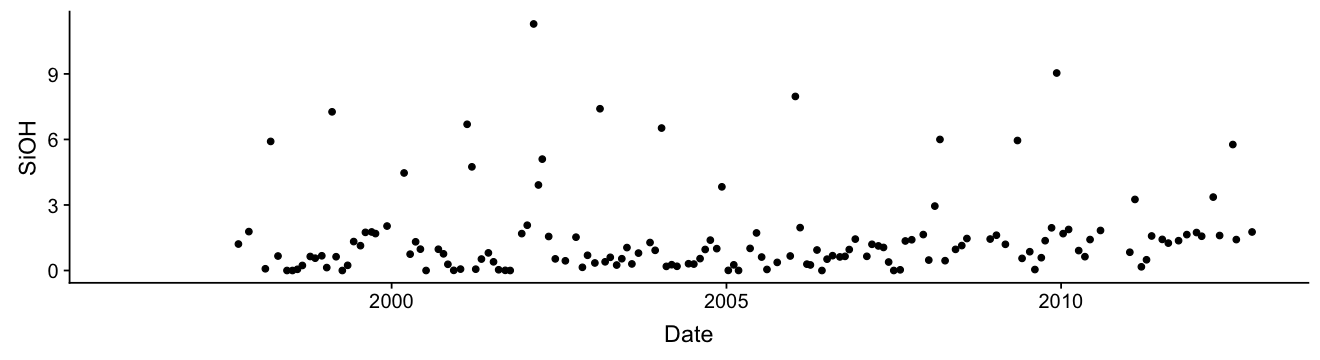

In [220]:
#ggplot() + geom_point(data=SST_above_mld, aes(x=Date,y=depthdiff))
ggplot() + geom_point(data=SiOH_above_mld, aes(x=Date,y=SiOH))

In [221]:
# create day of year and month columsn for aggregate plotting
SiOH_above_mld$dyear <- as.Date(format(SiOH_above_mld$Date, format="%m-%d"),format="%m-%d")

SiOH_above_mld$month <- format(SiOH_above_mld$Date, format="%m")

#split data into two regimes:
SiOH_above_mld_R1 <- SiOH_above_mld[!SiOH_above_mld$Date>as.Date('2000-10-30') & !SiOH_above_mld$Date<as.Date('1996-01-01'),]
SiOH_above_mld_R2 <- SiOH_above_mld[!SiOH_above_mld$Date<as.Date('2006-06-30') & !SiOH_above_mld$Date>as.Date('2010-12-31'),]

In [222]:
SiOH_above_R1ctDate <- as.POSIXlt(SiOH_above_mld_R1$Date)
SiOH_above_R2ctDate <- as.POSIXlt(SiOH_above_mld_R2$Date)

SiOH_above_R1yday <- SiOH_above_R1ctDate$yday
SiOH_above_R2yday <- SiOH_above_R2ctDate$yday

In [223]:
str(SiOH_above_mld_R1)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	57 obs. of  4 variables:
 $ Date : Date, format: "1996-01-12" "1996-02-13" ...
 $ SiOH : num  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
 $ dyear: Date, format: "2019-01-12" "2019-02-13" ...
 $ month: chr  "01" "02" "03" "04" ...


In [224]:
options(repr.plot.width=11, repr.plot.height=3)

SiOH_1 <- ggplot() + geom_point(data=SiOH_above_mld_R1,aes(x=dyear, y=SiOH, col='Regime 1'))+ #scale_y_continuous(trans = "reverse", limits = c(70,0), breaks=seq(70,0,-10))+
geom_point(data=SiOH_above_mld_R2,aes(x=dyear, y=SiOH, col='Regime 2')) + 
scale_x_date(date_breaks = "months", labels = date_format('%m'))+
ylab('SiOH[µM]') + xlab('Month of year') + labs(col='Regime')

In [225]:
# plot boxplot of distribution over the year per group
SiOH_2 <- ggplot() + geom_boxplot(data=SiOH_above_mld_R1,aes(x=reorder(month,dyear), y=SiOH, col='Regime 1'))+ #scale_y_continuous(trans = "reverse", limits = c(70,0), breaks=seq(70,0,-10))+
geom_boxplot(data=SiOH_above_mld_R2,aes(x=reorder(month,dyear), y=SiOH, col='Regime 2'), alpha=0.5)+ 
scale_x_discrete(limits=c("01","02","03","04","05","06","07","08","09","10","11","12"))+
#scale_x_continous(breaks = "months", labels = date_format('%m'))+
ylab('SiOH [µM]') + xlab('Month of year') + labs(col='Regime')

Warning message:
“Removed 27 rows containing missing values (geom_point).”Warning message:
“Removed 10 rows containing missing values (geom_point).”Warning message:
“Removed 27 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 10 rows containing non-finite values (stat_boxplot).”

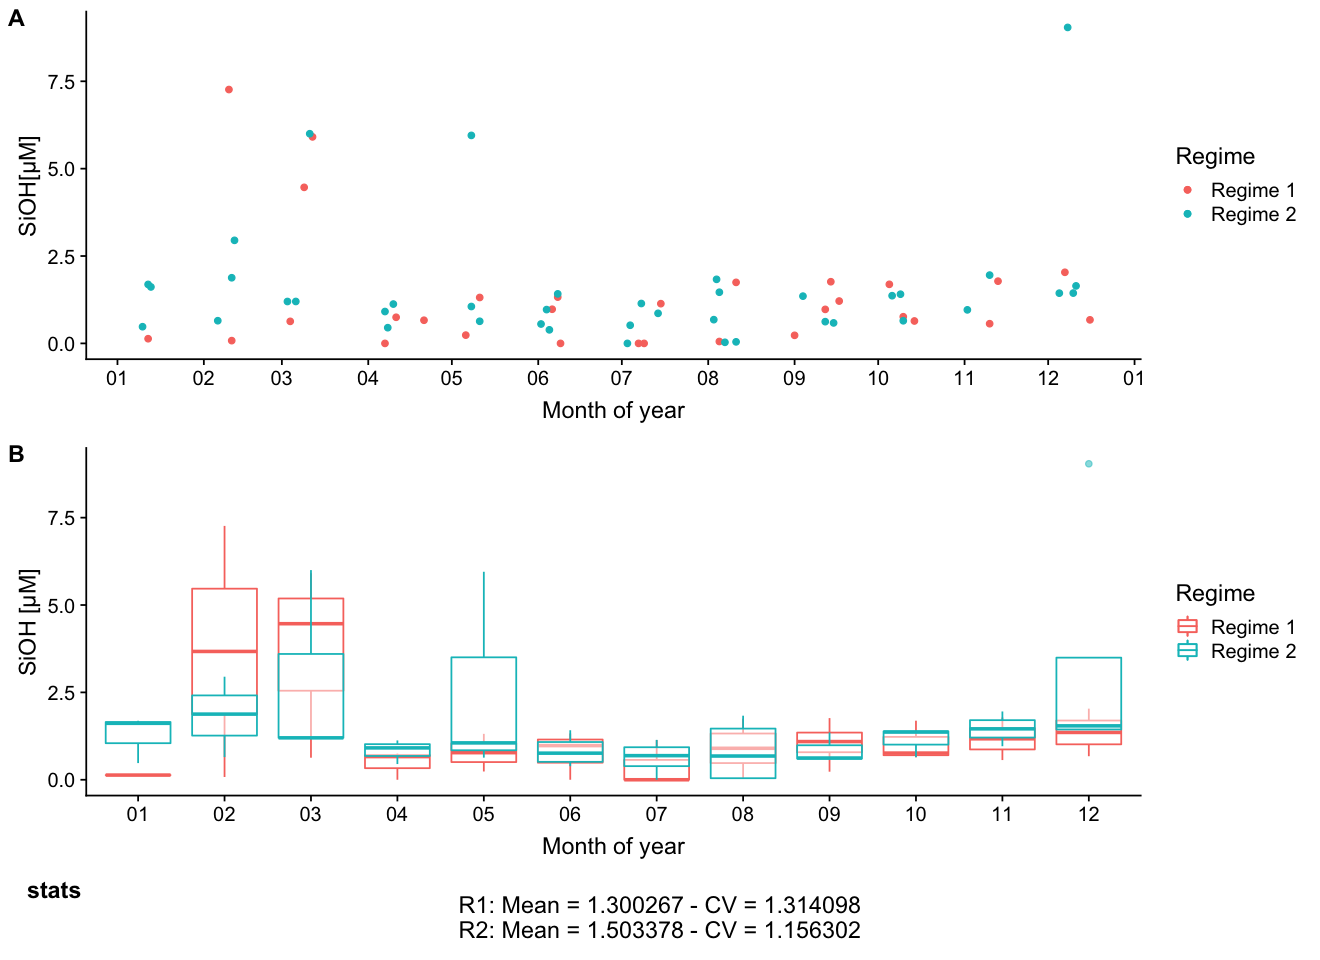

In [226]:
options(repr.plot.width=11, repr.plot.height=8)
SiOHmeanR1 <- mean(SiOH_above_mld_R1$SiOH, na.rm=T)
SiOHmeanR2 <- mean(SiOH_above_mld_R2$SiOH, na.rm=T)
SiOHcvR1 <- sd(SiOH_above_mld_R1$SiOH, na.rm=T)/mean(SiOH_above_mld_R1$SiOH, na.rm=T)
SiOHcvR2 <- sd(SiOH_above_mld_R2$SiOH, na.rm=T)/mean(SiOH_above_mld_R2$SiOH, na.rm=T)
SiOHstats <- ggdraw() + draw_label(sprintf(" R1: Mean = %f - CV = %f \nR2: Mean = %f - CV = %f", SiOHmeanR1, SiOHcvR1, SiOHmeanR2, SiOHcvR2))
plot_grid(SiOH_1, SiOH_2, SiOHstats, ncol = 1,labels = c("A", "B","stats"), rel_heights = c(1,1,0.2))

In [227]:
Si1 <- SiOH_above_mld_R1 %>% 
        group_by(month) %>% 
        summarise(
            dyear = mean(dyear),
            mean = mean(SiOH, na.rm=T),
            median = median(SiOH, na.rm=T)
        )

Si2 <- SiOH_above_mld_R2 %>% 
        group_by(month) %>% 
        summarise(
            dyear = mean(dyear),
            mean = mean(SiOH, na.rm=T),
            median = median(SiOH, na.rm=T)
        )

Warning message:
“Removed 27 rows containing missing values (geom_point).”Warning message:
“Removed 10 rows containing missing values (geom_point).”

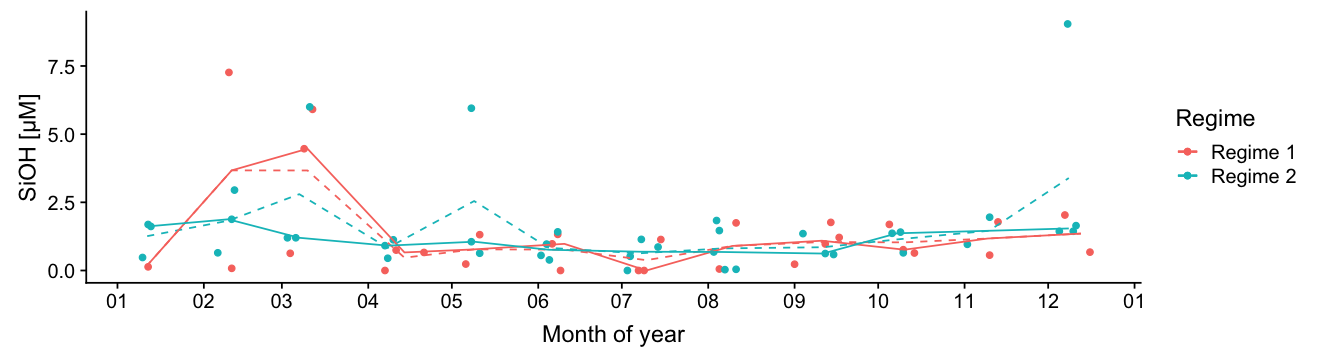

In [228]:
options(repr.plot.width=11, repr.plot.height=3)
ggplot() + geom_point(data=SiOH_above_mld_R1,aes(x=dyear, y=SiOH, col='Regime 1'))+ #scale_y_continuous(trans = 'reverse', limits = c(70,0), breaks=seq(70,0,-10))+
geom_point(data=SiOH_above_mld_R2,aes(x=dyear, y=SiOH, col='Regime 2')) +
geom_line(data=Si1,aes(x=dyear, y=mean, col='Regime 1'), linetype=2) +
geom_line(data=Si2,aes(x=dyear, y=mean, col='Regime 2'), linetype=2) +
geom_line(data=Si1,aes(x=dyear, y=median, col='Regime 1'), linetype=1) +
geom_line(data=Si2,aes(x=dyear, y=median, col='Regime 2'), , linetype=1) +
scale_x_date(date_breaks = 'months', labels = date_format('%m'))+
ylab('SiOH [µM]') + xlab('Month of year') + labs(col='Regime')

# write N above MLD into csv

In [229]:
SiOH_above_R1 <- data.frame(SiOH = SiOH_above_mld_R1$SiOH, month = SiOH_above_mld_R1$month, yday = SiOH_above_R1yday)
SiOH_above_R2 <- data.frame(SiOH = SiOH_above_mld_R2$SiOH, month = SiOH_above_mld_R2$month, yday = SiOH_above_R2yday)

In [231]:
# Write CSV in R
write.csv(SiOH_above_R1, file = "DATA_modelverification/SiOH_above_R1.csv")

# GET NITRATE 

In [232]:
NO2NO3 <- niskin %>%
  select(Date, NO3_NO2, Depth_real) %>%
  gather(key='key',value = "value", -Date, -Depth_real)
head(NO2NO3)

Date,Depth_real,key,value
1995-11-08,1.5,NO3_NO2,NA
1995-11-08,6.5,NO3_NO2,NA
1995-11-08,15.0,NO3_NO2,NA
1995-11-08,25.0,NO3_NO2,NA
1995-11-08,35.0,NO3_NO2,NA
1995-11-08,54.5,NO3_NO2,NA


In [233]:
NO2NO3_int <- NO2NO3 %>%
    group_by(Date) %>%
    do(data.frame(value_int = with(.,oceApprox(Depth_real, value, zz, "rr")), depth = zz)) 

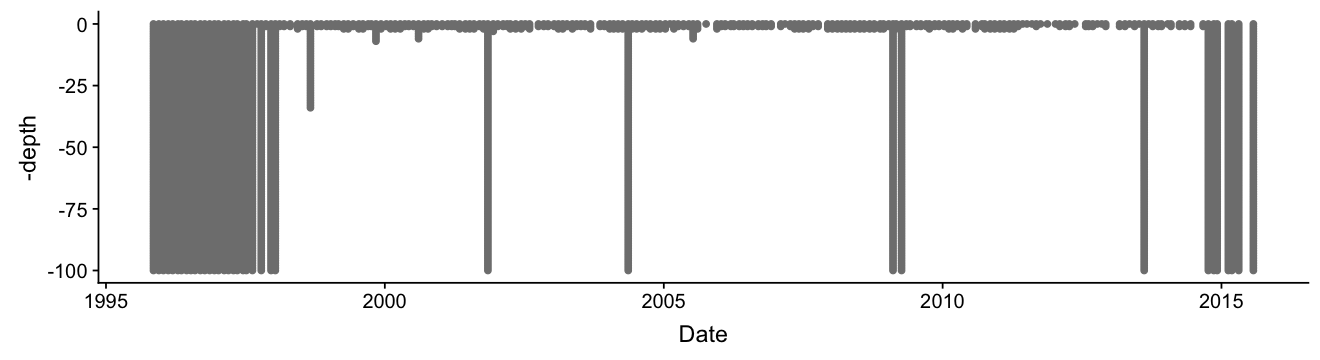

In [234]:
options(repr.plot.width=11, repr.plot.height=3)
ggplot(NO2NO3_int[is.na(NO2NO3_int$value_int),], aes(x=Date,y=-depth,col=value_int))+geom_point()

In [235]:
merge_NO2NO3_mld <- merge(NO2NO3_int, MLD2EuZ, by="Date")

merge_NO2NO3_mld$depthdiff <- merge_NO2NO3_mld$MLD2015 - merge_NO2NO3_mld$depth

In [236]:
NO2NO3_above_mld <- merge_NO2NO3_mld %>%
  group_by(Date) %>% # this groups it by the run number 
  filter(depthdiff > 0) %>% # only keep values above MLD
  summarize(NO2NO3=mean(value_int, na.rm=T))

head(NO2NO3_above_mld)
#niskin_at_mld_filtered <- niskin_at_mld[niskin_at_mld$depthdiff>-15,] # only take values up to 17 meters below MLD

Date,NO2NO3
1996-01-12,NaN
1996-02-13,NaN
1996-03-13,NaN
1996-04-16,NaN
1996-05-09,NaN
1996-06-12,NaN


Warning message:
“Removed 29 rows containing missing values (geom_point).”

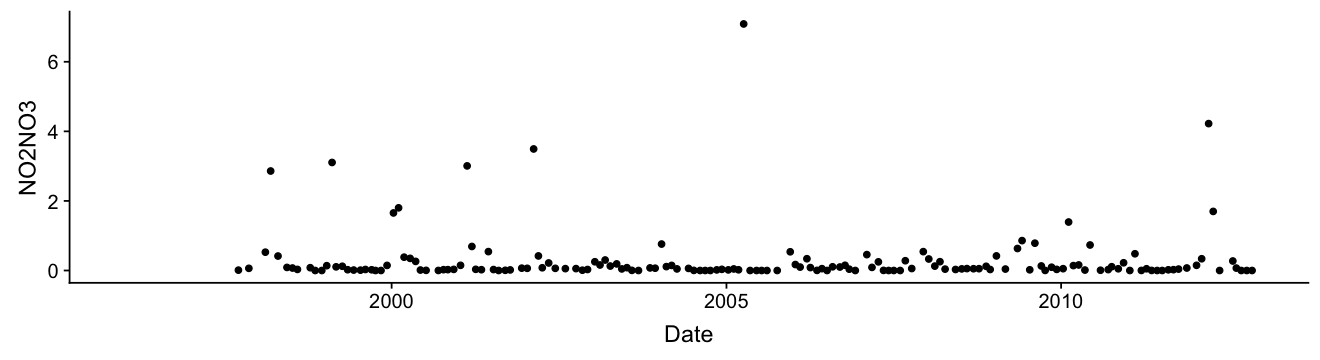

In [237]:
#ggplot() + geom_point(data=SST_above_mld, aes(x=Date,y=depthdiff))
ggplot() + geom_point(data=NO2NO3_above_mld, aes(x=Date,y=NO2NO3))

In [238]:
# create day of year and month columsn for aggregate plotting
NO2NO3_above_mld$dyear <- as.Date(format(NO2NO3_above_mld$Date, format="%m-%d"),format="%m-%d")

NO2NO3_above_mld$month <- format(NO2NO3_above_mld$Date, format="%m")

#split data into two regimes:
NO2NO3_above_mld_R1 <- NO2NO3_above_mld[!NO2NO3_above_mld$Date>as.Date('2000-10-30') & !NO2NO3_above_mld$Date<as.Date('1996-01-01'),]
NO2NO3_above_mld_R2 <- NO2NO3_above_mld[!NO2NO3_above_mld$Date<as.Date('2006-06-30') & !NO2NO3_above_mld$Date>as.Date('2010-12-31'),]

In [239]:
NO2NO3_above_R1ctDate <- as.POSIXlt(NO2NO3_above_mld_R1$Date)
NO2NO3_above_R2ctDate <- as.POSIXlt(NO2NO3_above_mld_R2$Date)

NO2NO3_above_R1yday <- NO2NO3_above_R1ctDate$yday
NO2NO3_above_R2yday <- NO2NO3_above_R2ctDate$yday

In [240]:
str(NO2NO3_above_mld_R1)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	57 obs. of  4 variables:
 $ Date  : Date, format: "1996-01-12" "1996-02-13" ...
 $ NO2NO3: num  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
 $ dyear : Date, format: "2019-01-12" "2019-02-13" ...
 $ month : chr  "01" "02" "03" "04" ...


In [241]:
options(repr.plot.width=11, repr.plot.height=3)

NO2NO3_1 <- ggplot() + geom_point(data=NO2NO3_above_mld_R1,aes(x=dyear, y=NO2NO3, col='Regime 1'))+ #scale_y_continuous(trans = "reverse", limits = c(70,0), breaks=seq(70,0,-10))+
geom_point(data=NO2NO3_above_mld_R2,aes(x=dyear, y=NO2NO3, col='Regime 2')) + 
scale_x_date(date_breaks = "months", labels = date_format('%m'))+
ylab('NO3+NO3 [µM]') + xlab('Month of year') + labs(col='Regime')

In [242]:
# plot boxplot of distribution over the year per group
NO2NO3_2 <- ggplot() + geom_boxplot(data=NO2NO3_above_mld_R1,aes(x=reorder(month,dyear), y=NO2NO3, col='Regime 1'))+ #scale_y_continuous(trans = "reverse", limits = c(70,0), breaks=seq(70,0,-10))+
geom_boxplot(data=NO2NO3_above_mld_R2,aes(x=reorder(month,dyear), y=NO2NO3, col='Regime 2'), alpha=0.5)+ 
scale_x_discrete(limits=c("01","02","03","04","05","06","07","08","09","10","11","12"))+
#scale_x_continous(breaks = "months", labels = date_format('%m'))+
ylab('NO3+NO3 [µM]') + xlab('Month of year') + labs(col='Regime')

Warning message:
“Removed 25 rows containing missing values (geom_point).”Warning message:
“Removed 2 rows containing missing values (geom_point).”Warning message:
“Removed 25 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”

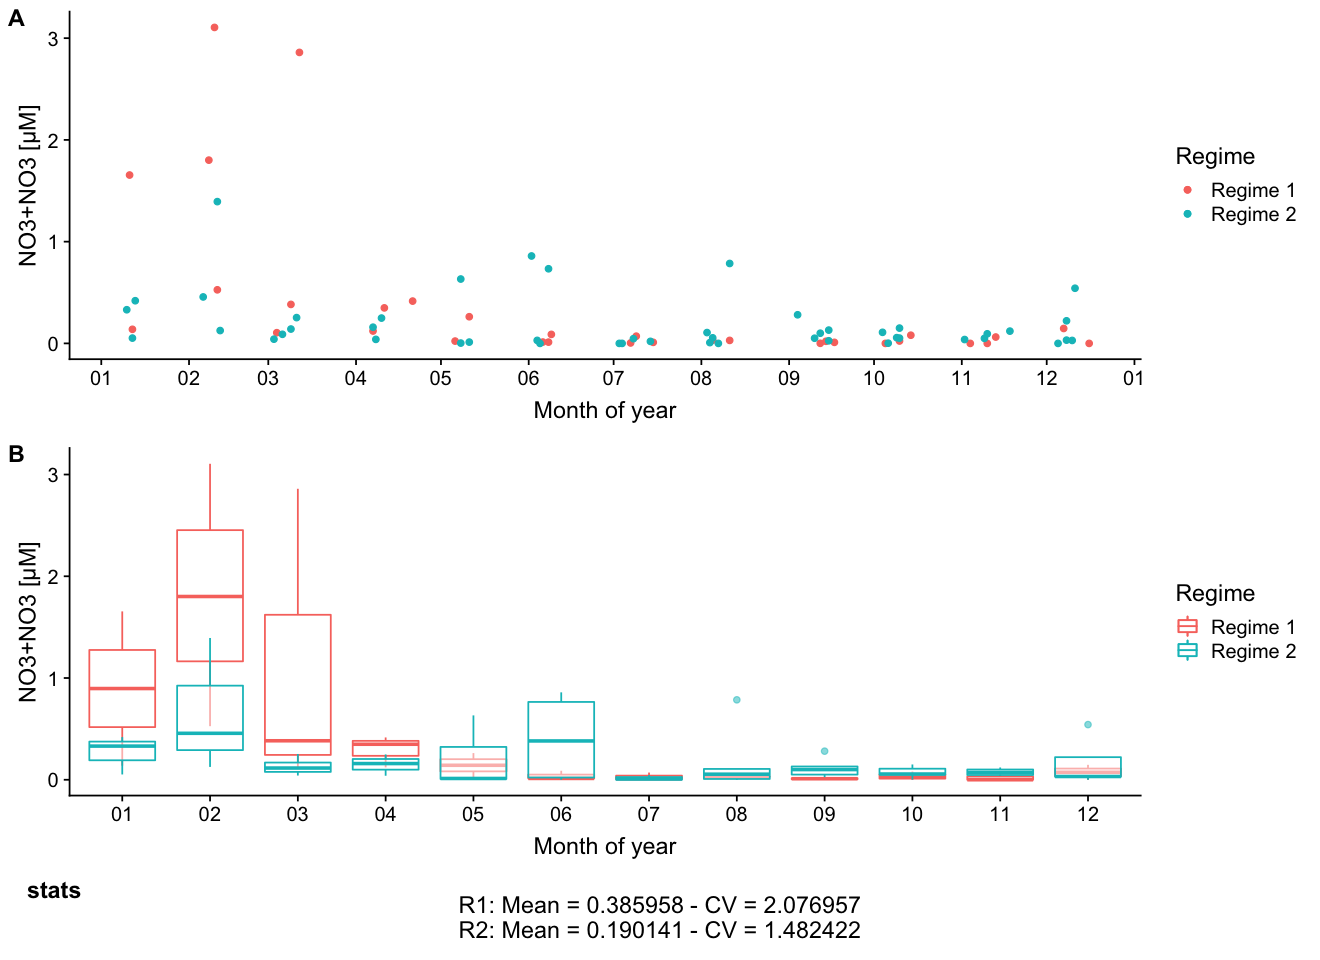

In [243]:
options(repr.plot.width=11, repr.plot.height=8)
NO2NO3meanR1 <- mean(NO2NO3_above_mld_R1$NO2NO3, na.rm=T)
NO2NO3meanR2 <- mean(NO2NO3_above_mld_R2$NO2NO3, na.rm=T)
NO2NO3cvR1 <- sd(NO2NO3_above_mld_R1$NO2NO3, na.rm=T)/mean(NO2NO3_above_mld_R1$NO2NO3, na.rm=T)
NO2NO3cvR2 <- sd(NO2NO3_above_mld_R2$NO2NO3, na.rm=T)/mean(NO2NO3_above_mld_R2$NO2NO3, na.rm=T)
NO2NO3stats <- ggdraw() + draw_label(sprintf(" R1: Mean = %f - CV = %f \nR2: Mean = %f - CV = %f", NO2NO3meanR1, NO2NO3cvR1, NO2NO3meanR2, NO2NO3cvR2))
plot_grid(NO2NO3_1, NO2NO3_2, NO2NO3stats, ncol = 1,labels = c("A", "B","stats"), rel_heights = c(1,1,0.2))

In [244]:
N1 <- NO2NO3_above_mld_R1 %>% 
        group_by(month) %>% 
        summarise(
            dyear = mean(dyear),
            mean = mean(NO2NO3, na.rm=T),
            median = median(NO2NO3, na.rm=T)
        )

N2 <- NO2NO3_above_mld_R2 %>% 
        group_by(month) %>% 
        summarise(
            dyear = mean(dyear),
            mean = mean(NO2NO3, na.rm=T),
            median = median(NO2NO3, na.rm=T)
        )

Warning message:
“Removed 25 rows containing missing values (geom_point).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

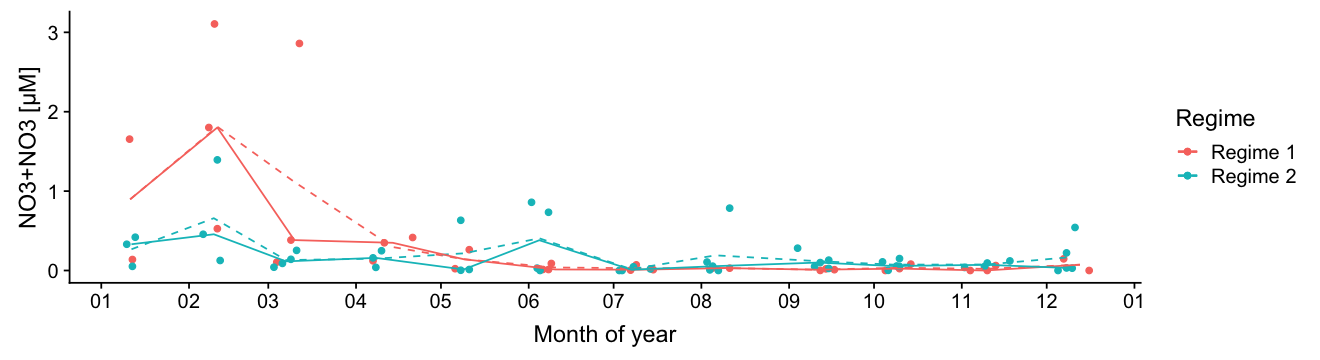

In [245]:
options(repr.plot.width=11, repr.plot.height=3)
ggplot() + geom_point(data=NO2NO3_above_mld_R1,aes(x=dyear, y=NO2NO3, col='Regime 1'))+ #scale_y_continuous(trans = 'reverse', limits = c(70,0), breaks=seq(70,0,-10))+
geom_point(data=NO2NO3_above_mld_R2,aes(x=dyear, y=NO2NO3, col='Regime 2')) +
geom_line(data=N1,aes(x=dyear, y=mean, col='Regime 1'), linetype=2) +
geom_line(data=N2,aes(x=dyear, y=mean, col='Regime 2'), linetype=2) +
geom_line(data=N1,aes(x=dyear, y=median, col='Regime 1'), linetype=1) +
geom_line(data=N2,aes(x=dyear, y=median, col='Regime 2'), , linetype=1) +
scale_x_date(date_breaks = 'months', labels = date_format('%m'))+
ylab('NO3+NO3 [µM]') + xlab('Month of year') + labs(col='Regime')

# write N above MLD into csv

In [246]:
NO2NO3_above_R1 <- data.frame(NO2NO3 = NO2NO3_above_mld_R1$NO2NO3, month = NO2NO3_above_mld_R1$month, yday = NO2NO3_above_R1yday)
NO2NO3_above_R2 <- data.frame(NO2NO3 = NO2NO3_above_mld_R2$NO2NO3, month = NO2NO3_above_mld_R2$month, yday = NO2NO3_above_R2yday)

In [247]:
# Write CSV in R
write.csv(NO2NO3_above_R1, file = "DATA_modelverification/NO2NO3_above_R1.csv")

# GET PON - DETRITUS; LETS TRY

In [57]:
'niskin$PON_ug_L'
'niskin$DON_USF_uM'

[1] "niskin$PON_ug_L"

[1] "niskin$DON_USF_uM"

In [58]:
PON <- niskin %>%
  select(Date, PON_ug_L, Depth_real) %>%
  gather(key='key',value = "value", -Date, -Depth_real)
head(NO2NO3)

Date,Depth_real,key,value
1995-11-08,1.5,NO3_NO2,NA
1995-11-08,6.5,NO3_NO2,NA
1995-11-08,15.0,NO3_NO2,NA
1995-11-08,25.0,NO3_NO2,NA
1995-11-08,35.0,NO3_NO2,NA
1995-11-08,54.5,NO3_NO2,NA


In [63]:
PON_int <- PON %>%
    group_by(Date) %>%
    do(data.frame(value_int = with(.,oceApprox(Depth_real, value, zz, "rr")), depth = zz)) 

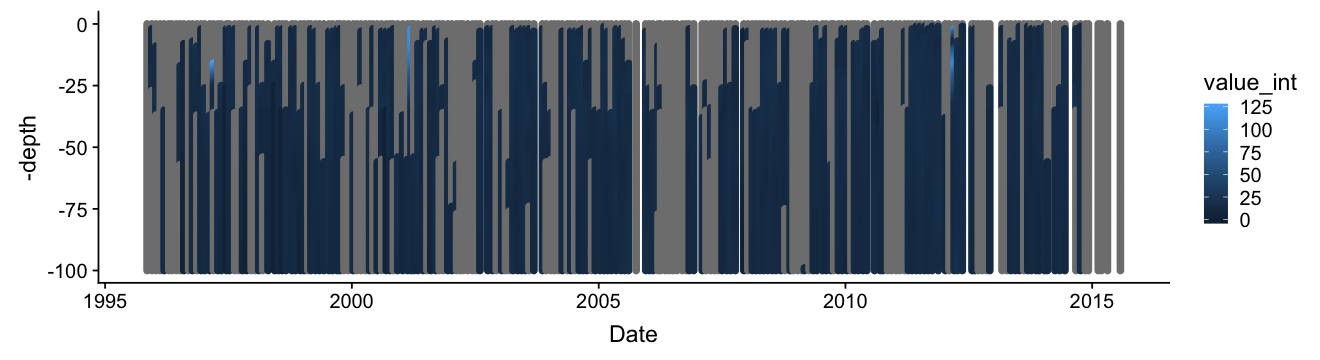

In [64]:
options(repr.plot.width=11, repr.plot.height=3)
ggplot(PON_int, aes(x=Date,y=-depth,col=value_int))+geom_point()

In [65]:
merge_PON_mld <- merge(PON_int, MLD2EuZ, by="Date")

merge_PON_mld$depthdiff <- merge_PON_mld$MLD2015 - merge_PON_mld$depth

In [66]:
PON_above_mld <- merge_PON_mld %>%
  group_by(Date) %>% # this groups it by the run number 
  filter(depthdiff > 0) %>% # only keep values above MLD
  summarize(value=mean(value_int, na.rm=T))

head(PON_above_mld)
#niskin_at_mld_filtered <- niskin_at_mld[niskin_at_mld$depthdiff>-15,] # only take values up to 17 meters below MLD

Date,value
1996-01-12,14.97543
1996-02-13,NaN
1996-03-13,NaN
1996-04-16,NaN
1996-05-09,NaN
1996-06-12,NaN


Warning message:
“Removed 92 rows containing missing values (geom_point).”

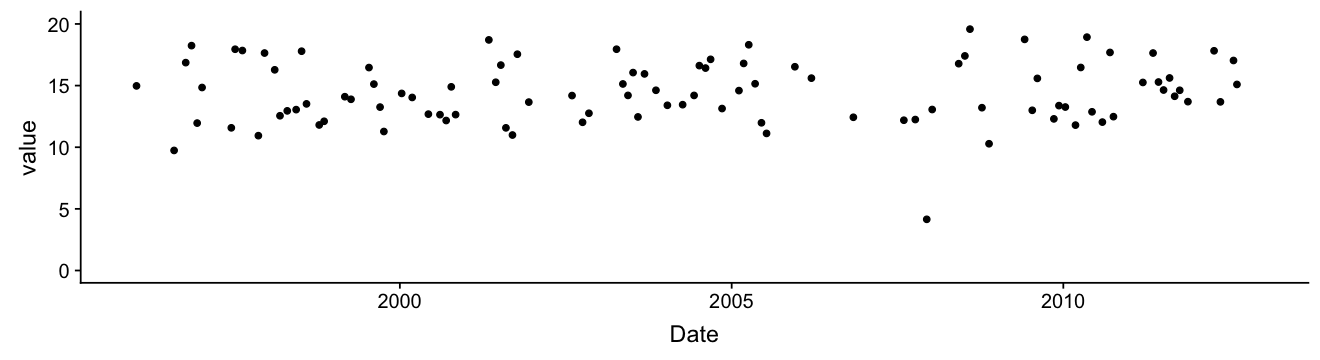

In [68]:
#ggplot() + geom_point(data=SST_above_mld, aes(x=Date,y=depthdiff))
ggplot() + geom_point(data=PON_above_mld, aes(x=Date,y=value)) + ylim(0,20)

In [69]:
DON <- niskin %>%
  select(Date, DON_USF_uM, Depth_real) %>%
  gather(key='key',value = "value", -Date, -Depth_real)
head(DON)

Date,Depth_real,key,value
1995-11-08,1.5,DON_USF_uM,NA
1995-11-08,6.5,DON_USF_uM,NA
1995-11-08,15.0,DON_USF_uM,NA
1995-11-08,25.0,DON_USF_uM,NA
1995-11-08,35.0,DON_USF_uM,NA
1995-11-08,54.5,DON_USF_uM,NA


In [70]:
DON_int <- DON %>%
    group_by(Date) %>%
    do(data.frame(value_int = with(.,oceApprox(Depth_real, value, zz, "rr")), depth = zz)) 

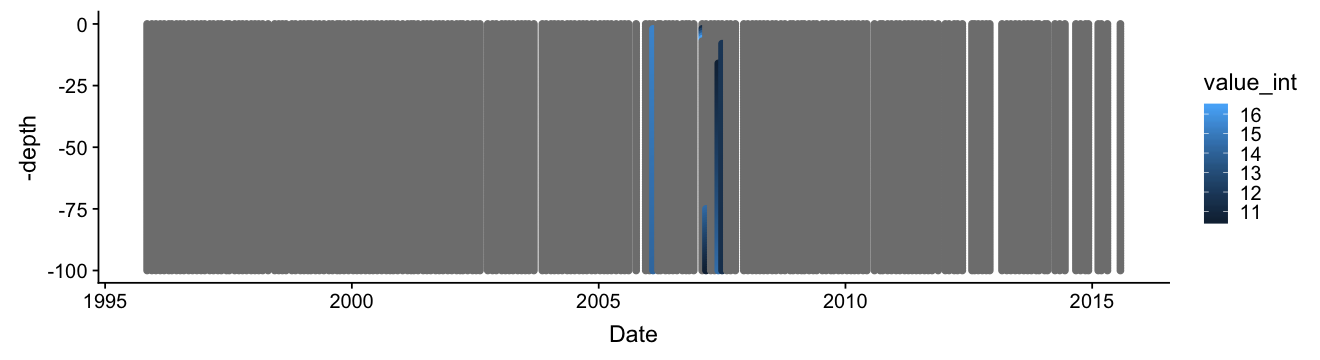

In [71]:
options(repr.plot.width=11, repr.plot.height=3)
ggplot(DON_int, aes(x=Date,y=-depth,col=value_int))+geom_point()

## detritus data NO GOOD!

# GET Phytoplankton DATA!

## - Diatoms
## - Nanos
## - Dinos
## - Coccos

In [77]:
#PhytoAbundances
phyto_filtered <- read.csv("DATA_processed/PhytoAbund_filtered.csv")
phyto_filtered$Date <- as.Date(phyto_filtered$date, format="%Y-%m-%d")

In [78]:
head(phyto_filtered)

X.1,X,CruiseID,lon,lat,date,month,year,depth,taxon,group,abundance,Date
1,1,93HG_001,-64.67,10.5,1995-11-08,11,1995,1,Amphora_sp,DIATOMS,0,1995-11-08
2,2,93HG_001,-64.67,10.5,1995-11-08,11,1995,7,Amphora_sp,DIATOMS,0,1995-11-08
3,3,93HG_001,-64.67,10.5,1995-11-08,11,1995,15,Amphora_sp,DIATOMS,0,1995-11-08
4,4,93HG_001,-64.67,10.5,1995-11-08,11,1995,25,Amphora_sp,DIATOMS,0,1995-11-08
5,5,93HG_001,-64.67,10.5,1995-11-08,11,1995,35,Amphora_sp,DIATOMS,0,1995-11-08
6,6,93HG_001,-64.67,10.5,1995-11-08,11,1995,55,Amphora_sp,DIATOMS,0,1995-11-08


In [88]:
PhyGroupAbund <- phyto_filtered[!phyto_filtered$group == 'TOTAL',] %>%
  group_by(Date,group, depth) %>%
  summarize(GroupAbund = sum(abundance)) %>%
  select(Date, group, GroupAbund,depth) %>%
  gather(key='key',value = "value", -Date,-group, -depth)
head(PhyGroupAbund)

Date,group,depth,key,value
1995-11-08,COCCOLITHOPHORIDS,1,GroupAbund,0.000
1995-11-08,COCCOLITHOPHORIDS,7,GroupAbund,0.500
1995-11-08,COCCOLITHOPHORIDS,15,GroupAbund,0.500
1995-11-08,COCCOLITHOPHORIDS,25,GroupAbund,0.000
1995-11-08,COCCOLITHOPHORIDS,35,GroupAbund,4.646
1995-11-08,COCCOLITHOPHORIDS,55,GroupAbund,2.223


In [116]:
PHYTO_int <- PhyGroupAbund %>%
    group_by(Date,group) %>%
    do(data.frame(value_int = with(.,oceApprox(depth, value, zz, "rr")), depth = zz)) 

In [117]:
head(PHYTO_int[PHYTO_int$group=='DIATOMS',])

Date,group,value_int,depth
1995-11-08,DIATOMS,NA,0
1995-11-08,DIATOMS,59.00,1
1995-11-08,DIATOMS,61.25,2
1995-11-08,DIATOMS,63.50,3
1995-11-08,DIATOMS,65.75,4
1995-11-08,DIATOMS,68.00,5


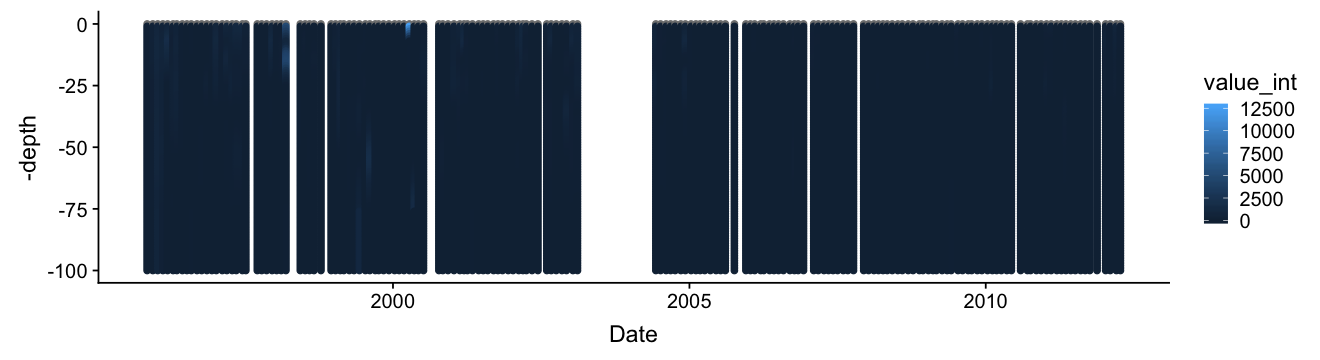

In [121]:
options(repr.plot.width=11, repr.plot.height=3)
ggplot(PHYTO_int[PHYTO_int$group=='DIATOMS',], aes(x=Date,y=-depth,col=value_int))+geom_point()

In [122]:
merge_PHYTO_mld <- merge(PHYTO_int, MLD2EuZ, by="Date")

merge_PHYTO_mld$depthdiff <- merge_PHYTO_mld$MLD2015 - merge_PHYTO_mld$depth

In [123]:
PHYTO_above_mld <- merge_PHYTO_mld %>%
  group_by(Date, group) %>% # this groups it by the run number 
  filter(depthdiff > 0) %>% # only keep values above MLD
  summarize(value=mean(value_int, na.rm=T))

head(PHYTO_above_mld)
#niskin_at_mld_filtered <- niskin_at_mld[niskin_at_mld$depthdiff>-15,] # only take values up to 17 meters below MLD

Date,group,value
1996-01-12,COCCOLITHOPHORIDS,18.4454546
1996-01-12,CYANOBACTERIA,3.4674576
1996-01-12,DIATOMS,834.2520613
1996-01-12,DINOFLAGELLATES,46.6187303
1996-01-12,NANOFLAGELLATES,484.7180113
1996-01-12,OTHERS,0.5286857


Warning message:
“Removed 58 rows containing missing values (geom_point).”

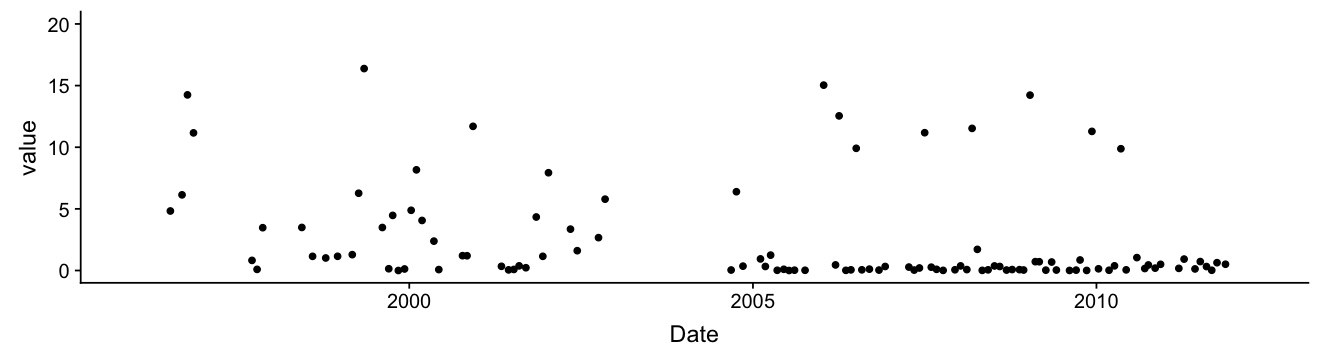

In [124]:
#ggplot() + geom_point(data=SST_above_mld, aes(x=Date,y=depthdiff))
ggplot() + geom_point(data=PHYTO_above_mld[PHYTO_above_mld$group=='DIATOMS',], aes(x=Date,y=value)) + ylim(0,20)

In [125]:
options(repr.plot.width=11, repr.plot.height=3)
facets <- c("COCCOLITHOPHORIDS", "CYANOBACTERIA", "DIATOMS", "DINOFLAGELLATES", "NANOFLAGELLATES","OTHERS")
colors <- c('#f35e5a','#a89005','#17b12b','#17b3b7','#5086ff','#ef43dc')
names(colors) <- facets

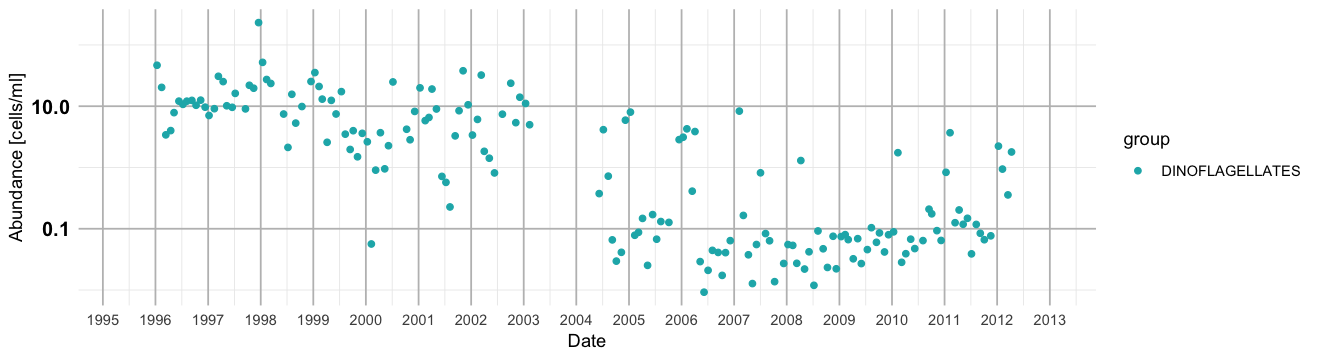

In [130]:
# plot each group inidividually
ggplot(PHYTO_above_mld[PHYTO_above_mld$group == facets[4],], aes(x = Date, y = value, col=group)) + 
  geom_point() + 
  scale_color_manual(values = colors) +
  theme_minimal()+ scale_y_log10()+
  theme(panel.grid.major = element_line(colour = 'grey')) + 
  #scale_y_continuous(trans = "reverse", limits = c(60,0))+
  scale_x_date(date_breaks = "years", date_labels='%Y', limits= c(as.Date("1995/6/1"), as.Date("2013/1/1")))+
    ylab('Abundance [cells/ml]') + theme(axis.text.y = element_text(face = "bold", color = "black", size = 12))

In [131]:
#split data into two regimes:
PGA_R1 <- PHYTO_above_mld[!PHYTO_above_mld$Date>as.Date('2000-10-30') & !PHYTO_above_mld$Date<as.Date('1996-01-01'),]
PGA_R2 <- PHYTO_above_mld[!PHYTO_above_mld$Date<as.Date('2006-06-30') & !PHYTO_above_mld$Date>as.Date('2010-12-31'),]

In [132]:
# create day of year and month columsn for aggregate plotting
PGA_R1$dyear <- as.Date(format(PGA_R1$Date, format="%m-%d"),format="%m-%d")
PGA_R2$dyear <- as.Date(format(PGA_R2$Date, format="%m-%d"),format="%m-%d")
PGA_R1$month <- format(PGA_R1$Date, format="%m")
PGA_R2$month <- format(PGA_R2$Date, format="%m")

In [199]:
# CHOOSE PHYTOPLANKTON TYPE:
pf <- facets[4]

In [200]:
PGA_R1ctDate <- as.POSIXlt(PGA_R1[PGA_R1$group == pf,]$Date)
PGA_R2ctDate <- as.POSIXlt(PGA_R2[PGA_R2$group == pf,]$Date)

PGA_R1yday <- PGA_R1ctDate$yday
PGA_R2yday <- PGA_R2ctDate$yday

In [201]:
options(repr.plot.width=11, repr.plot.height=3)

PGA1 <- ggplot() + geom_point(data=PGA_R1[PGA_R1$group == pf,],aes(x=dyear, y=value, col='Regime 1'))+ #scale_y_continuous(trans = "reverse", limits = c(60,0), breaks=seq(60,0,-10))+
geom_point(data=PGA_R2[PGA_R2$group == pf,],aes(x=dyear, y=value, col='Regime 2')) + 
scale_x_date(date_breaks = "months", labels = date_format('%m'))+
ylab('Abundance [cells/ml]') + xlab('Month of year') + labs(col='Regime')

In [202]:
PGA2 <- ggplot() + geom_boxplot(data=PGA_R1[PGA_R1$group == pf,],aes(x=reorder(month,dyear), y=value, col='Regime 1'))+ #scale_y_continuous(trans = "reverse", limits = c(60,0), breaks=seq(60,0,-10))+
geom_boxplot(data=PGA_R2[PGA_R2$group == pf,],aes(x=reorder(month,dyear), y=value, col='Regime 2'), alpha=0.5)+ 
#scale_x_continous(breaks = "months", labels = date_format('%m'))+
ylab('Abundance [cells/ml]') + xlab('Month of year') + labs(col='Regime')

In [203]:
mean(PGA_R1[PGA_R1$group == pf,]$value, na.rm=T)

[1] 17.00456

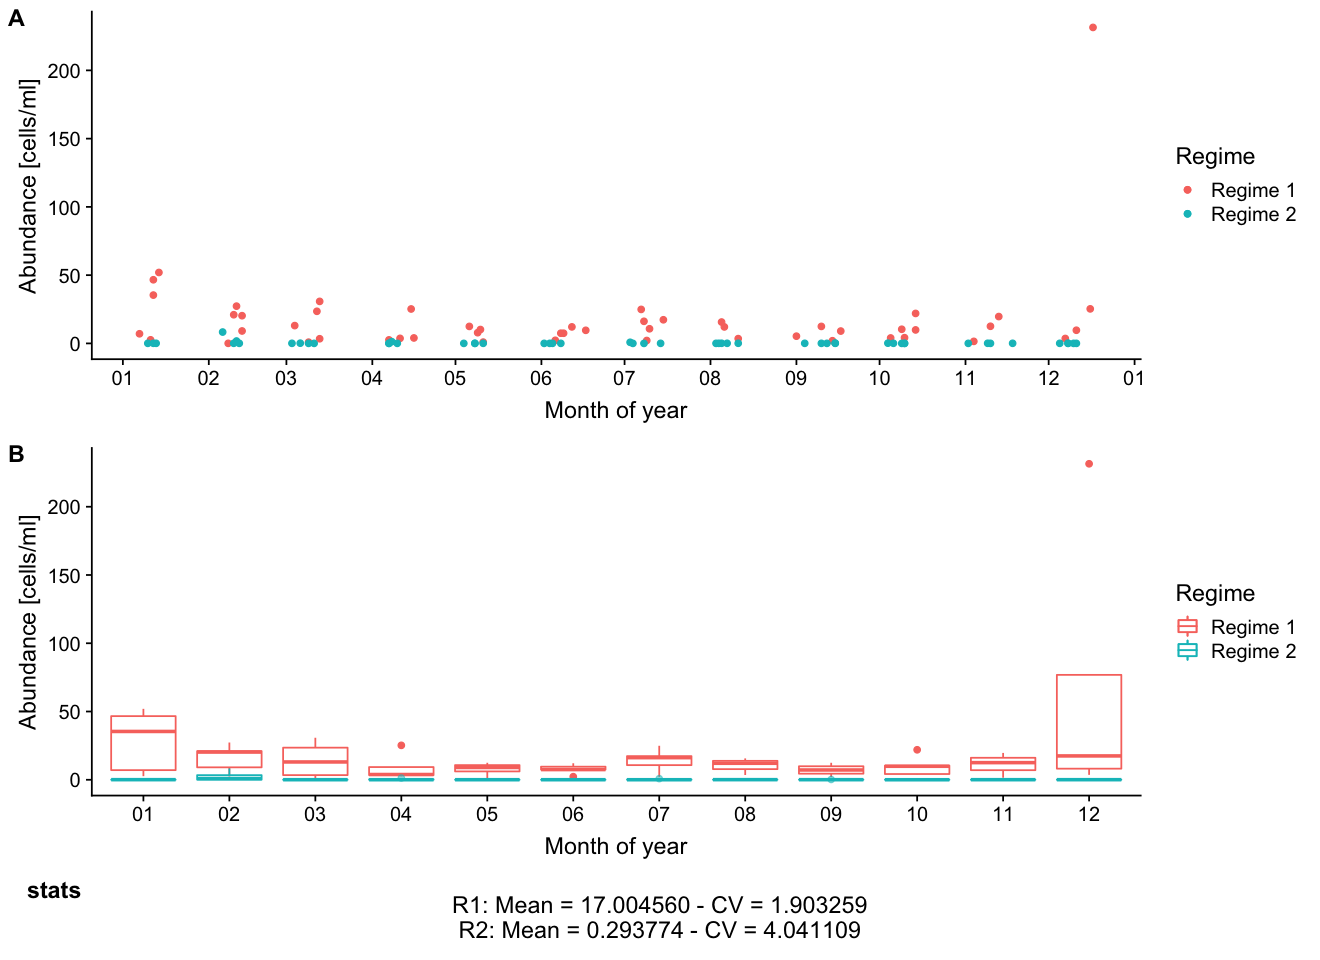

In [204]:
options(repr.plot.width=11, repr.plot.height=8)
PGAmeanR1 <- mean(PGA_R1[PGA_R1$group == pf,]$value, na.rm=T)
PGAmeanR2 <- mean(PGA_R2[PGA_R2$group == pf,]$value, na.rm=T)
PGAcvR1 <- sd(PGA_R1[PGA_R1$group == pf,]$value, na.rm=T)/mean(PGA_R1[PGA_R1$group == pf,]$value, na.rm=T)
PGAcvR2 <- sd(PGA_R2[PGA_R2$group == pf,]$value, na.rm=T)/mean(PGA_R2[PGA_R2$group == pf,]$value, na.rm=T)
PGAstats <- ggdraw() + draw_label(sprintf(" R1: Mean = %f - CV = %f \nR2: Mean = %f - CV = %f", PGAmeanR1, PGAcvR1, PGAmeanR2, PGAcvR2))
plot_grid(PGA1, PGA2, PGAstats, ncol = 1,labels = c("A", "B","stats"), rel_heights = c(1,1,0.2))

In [205]:
pf

[1] "DINOFLAGELLATES"

In [206]:
P1 <- PGA_R1 %>% 
        group_by(month,group) %>% 
        summarise(
            dyear = mean(dyear),
            mean = mean(value, na.rm=T),
            median = median(value, na.rm=T)
        )

P2 <- PGA_R2 %>% 
        group_by(month,group) %>% 
        summarise(
            dyear = mean(dyear),
            mean = mean(value, na.rm=T),
            median = median(value, na.rm=T)
        )

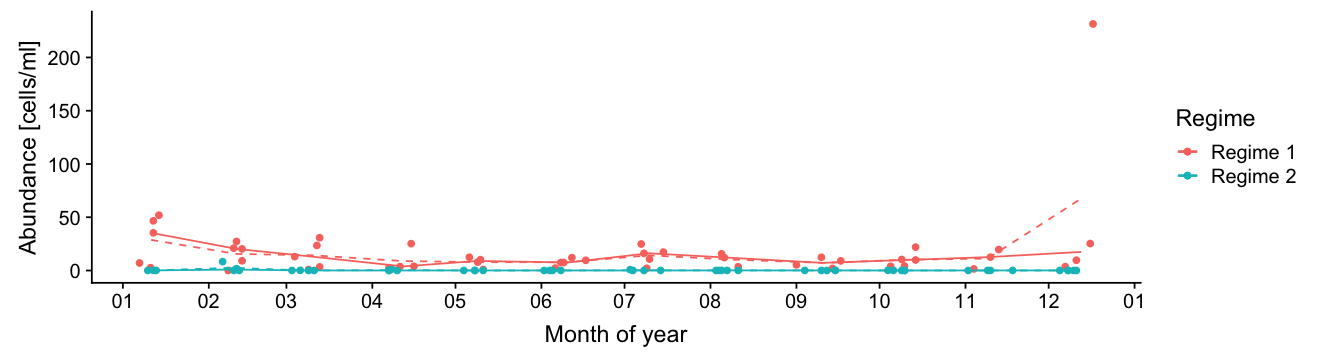

In [207]:
options(repr.plot.width=11, repr.plot.height=3)
ggplot() + geom_point(data=PGA_R1[PGA_R1$group == pf,],aes(x=dyear, y=value, col='Regime 1'))+ #scale_y_continuous(trans = 'reverse', limits = c(70,0), breaks=seq(70,0,-10))+
geom_point(data=PGA_R2[PGA_R2$group == pf,],aes(x=dyear, y=value, col='Regime 2')) +
geom_line(data=P1[P1$group == pf,],aes(x=dyear, y=mean, col='Regime 1'), linetype=2) +
geom_line(data=P2[P1$group == pf,],aes(x=dyear, y=mean, col='Regime 2'), linetype=2) +
geom_line(data=P1[P1$group == pf,],aes(x=dyear, y=median, col='Regime 1'), linetype=1) +
geom_line(data=P2[P1$group == pf,],aes(x=dyear, y=median, col='Regime 2'), , linetype=1) +
scale_x_date(date_breaks = 'months', labels = date_format('%m'))+
ylab('Abundance [cells/ml]') + xlab('Month of year') + labs(col='Regime')

# write N above MLD into csv

In [208]:
PGA_above_R1 <- data.frame(abundance = PGA_R1[PGA_R1$group == pf,]$value, month = PGA_R1[PGA_R1$group == pf,]$month, yday = PGA_R1yday)
PGA_above_R2 <- data.frame(abundance = PGA_R2[PGA_R2$group == pf,]$value, month = PGA_R2[PGA_R2$group == pf,]$month, yday = PGA_R2yday)

In [209]:
pf

[1] "DINOFLAGELLATES"

In [210]:
# Write CSV in R
write.csv(PGA_above_R1, file = paste("DATA_modelverification/",pf,"_above_R1.csv"))

# ZOOOOOPLANKTON


## get zooplankton data from ncdf file

In [272]:
#Zooplankton
zoodata <- read.csv("DATA_processed/Master_Zooplankton_Nov2017_Cleaned.csv")
zoodata$Date <- as.Date(zoodata$Date, format="%Y-%m-%d")

In [273]:
head(zoodata)

X,CRUISE,Date,YEAR,MONTH,Analyst,Mesh.Size,TOTAL.DENSITY,BIOMASS,ASH,⋯,NA.3,APPENDICULARIANS,SALPS,DOLIOLIDS,BIVALVES,H.CRUSTACEA,L.ANFIOXUS,LUCIFER,JUV..GASTROPOD,yday
1,71,2001-10-09,2001,10,Javier Gutierrez,500,213,15.9,3.3,⋯,NA,9.36,1.83,NA,NA,NA,,NA,,281
20,72,2001-11-06,2001,11,Javier Gutierrez,500,13,2.3,0.1,⋯,NA,0.52,0.52,NA,NA,NA,,NA,,309
39,73,2001-12-11,2001,12,Javier Gutierrez,500,9,0.7,0.2,⋯,NA,0.22,0.03,NA,0.03,0.26,,NA,,344
58,74,2002-01-10,2002,1,Javier Gutierrez,500,105,4.9,0.18,⋯,NA,0.10,18.00,NA,0.00,0.30,,0.4,,9
59,74,2002-01-10,2002,1,Javier Gutierrez,200,499,10.2,0.5,⋯,NA,3.20,37.30,NA,1.60,1.60,n.d.,NA,n.d.,9
96,75,2002-02-14,2002,2,Javier Gutierrez,200,612,12.9,2.6,⋯,NA,5.00,1.70,NA,NA,3.30,n.d.,NA,n.d.,44


In [280]:
ZOOdf <- zoodata %>%
  select(Date, TOTAL.DENSITY, BIOMASS, ASH, Mesh.Size) %>%
  gather(key='key',value = "value", -Date, -Mesh.Size)

ZOOdf$value <- as.numeric(ZOOdf$value)
head(ZOOdf)

Warning message:
“attributes are not identical across measure variables;
they will be dropped”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

Date,Mesh.Size,key,value
2001-10-09,500,TOTAL.DENSITY,213
2001-11-06,500,TOTAL.DENSITY,13
2001-12-11,500,TOTAL.DENSITY,9
2002-01-10,500,TOTAL.DENSITY,105
2002-01-10,200,TOTAL.DENSITY,499
2002-02-14,200,TOTAL.DENSITY,612


In [283]:
str(ZOOdf)

'data.frame':	909 obs. of  4 variables:
 $ Date     : Date, format: "2001-10-09" "2001-11-06" ...
 $ Mesh.Size: int  500 500 500 500 200 200 500 200 500 200 ...
 $ key      : chr  "TOTAL.DENSITY" "TOTAL.DENSITY" "TOTAL.DENSITY" "TOTAL.DENSITY" ...
 $ value    : num  213 13 9 105 499 612 NA 379 29 572 ...


Warning message:
“Removed 24 rows containing missing values (geom_point).”

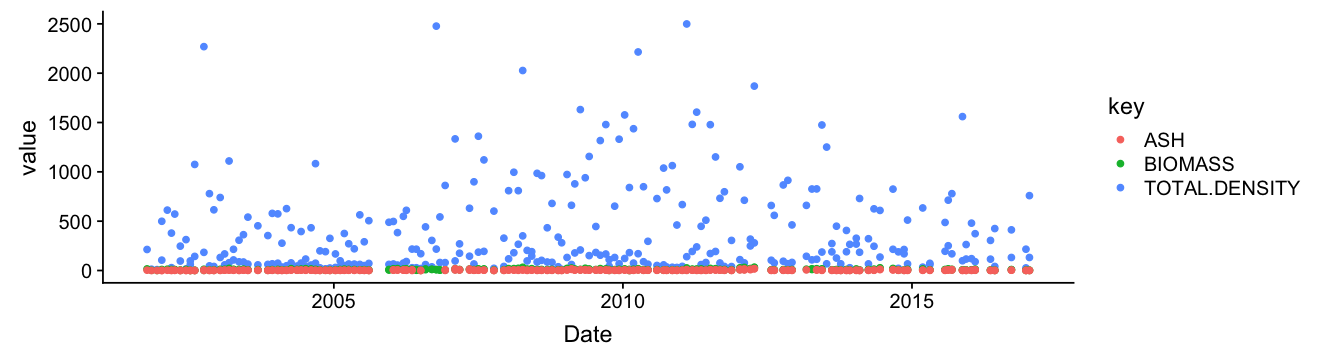

In [284]:
#ggplot() + geom_point(data=SST_above_mld, aes(x=Date,y=depthdiff))
ggplot() + geom_point(data=ZOOdf, aes(x=Date,y=value, col=key)) #+ ylim(0,20)

In [296]:
options(repr.plot.width=11, repr.plot.height=3)
zoofacets <- c(500, 200)
zoocolors <- c('#f35e5a','#a89005')
names(zoocolors) <- zoofacets

In [297]:
zoovalues <- c('TOTAL.DENSITY', 'BIOMASS', 'ASH')

Warning message:
“Removed 67 rows containing missing values (geom_point).”

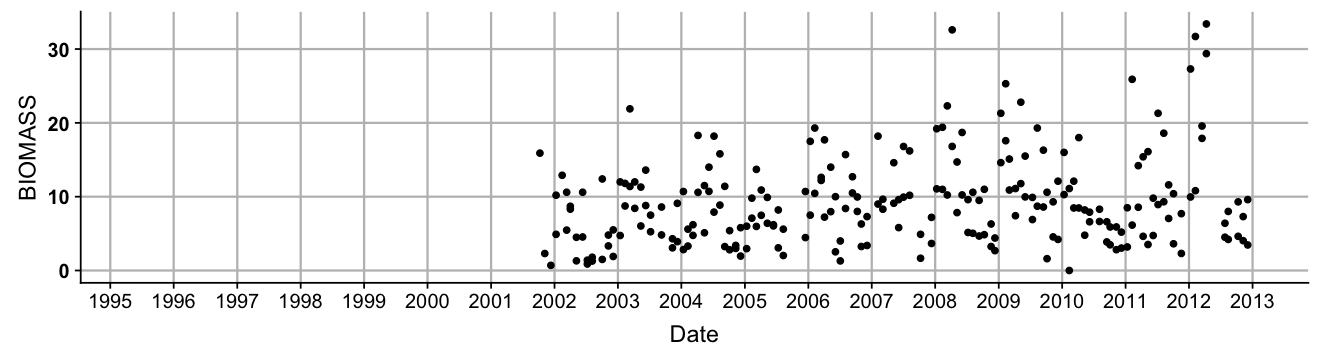

In [308]:
# plot each group inidividually
ggplot(ZOOdf[ZOOdf$key==zoovalues[2],], aes(x = Date, y = value)) + 
  geom_point() + 
  theme(panel.grid.major = element_line(colour = 'grey')) + 
  #scale_y_continuous(trans = "reverse", limits = c(60,0))+
  scale_x_date(date_breaks = "years", date_labels='%Y', limits= c(as.Date("1995/6/1"), as.Date("2013/1/1")))+
    ylab(paste(zoovalues[2])) + theme(axis.text.y = element_text(face = "bold", color = "black", size = 12))

# after
# here
# nothing 
# is 
# done 
# yet!!!

In [309]:
#split data into two regimes:
PGA_R1 <- PHYTO_above_mld[!PHYTO_above_mld$Date>as.Date('2000-10-30') & !PHYTO_above_mld$Date<as.Date('1996-01-01'),]
PGA_R2 <- PHYTO_above_mld[!PHYTO_above_mld$Date<as.Date('2006-06-30') & !PHYTO_above_mld$Date>as.Date('2010-12-31'),]

In [132]:
# create day of year and month columsn for aggregate plotting
PGA_R1$dyear <- as.Date(format(PGA_R1$Date, format="%m-%d"),format="%m-%d")
PGA_R2$dyear <- as.Date(format(PGA_R2$Date, format="%m-%d"),format="%m-%d")
PGA_R1$month <- format(PGA_R1$Date, format="%m")
PGA_R2$month <- format(PGA_R2$Date, format="%m")

In [199]:
# CHOOSE PHYTOPLANKTON TYPE:
zf <- zoofacets[1]

In [200]:
PGA_R1ctDate <- as.POSIXlt(PGA_R1[PGA_R1$group == pf,]$Date)
PGA_R2ctDate <- as.POSIXlt(PGA_R2[PGA_R2$group == pf,]$Date)

PGA_R1yday <- PGA_R1ctDate$yday
PGA_R2yday <- PGA_R2ctDate$yday

In [201]:
options(repr.plot.width=11, repr.plot.height=3)

PGA1 <- ggplot() + geom_point(data=PGA_R1[PGA_R1$group == pf,],aes(x=dyear, y=value, col='Regime 1'))+ #scale_y_continuous(trans = "reverse", limits = c(60,0), breaks=seq(60,0,-10))+
geom_point(data=PGA_R2[PGA_R2$group == pf,],aes(x=dyear, y=value, col='Regime 2')) + 
scale_x_date(date_breaks = "months", labels = date_format('%m'))+
ylab('Abundance [cells/ml]') + xlab('Month of year') + labs(col='Regime')

In [202]:
PGA2 <- ggplot() + geom_boxplot(data=PGA_R1[PGA_R1$group == pf,],aes(x=reorder(month,dyear), y=value, col='Regime 1'))+ #scale_y_continuous(trans = "reverse", limits = c(60,0), breaks=seq(60,0,-10))+
geom_boxplot(data=PGA_R2[PGA_R2$group == pf,],aes(x=reorder(month,dyear), y=value, col='Regime 2'), alpha=0.5)+ 
#scale_x_continous(breaks = "months", labels = date_format('%m'))+
ylab('Abundance [cells/ml]') + xlab('Month of year') + labs(col='Regime')

In [203]:
mean(PGA_R1[PGA_R1$group == pf,]$value, na.rm=T)

[1] 17.00456

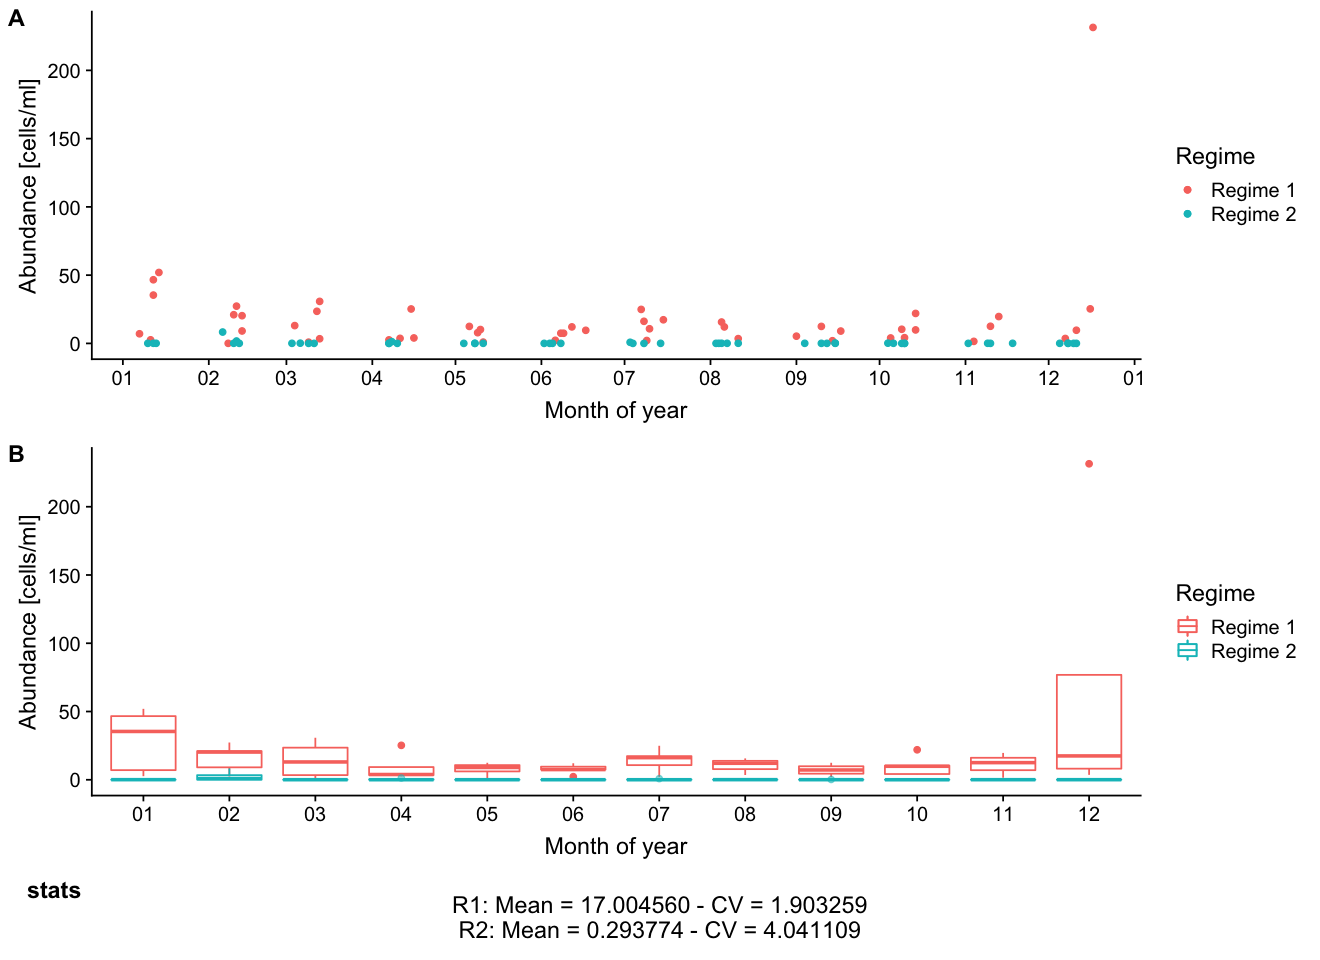

In [204]:
options(repr.plot.width=11, repr.plot.height=8)
PGAmeanR1 <- mean(PGA_R1[PGA_R1$group == pf,]$value, na.rm=T)
PGAmeanR2 <- mean(PGA_R2[PGA_R2$group == pf,]$value, na.rm=T)
PGAcvR1 <- sd(PGA_R1[PGA_R1$group == pf,]$value, na.rm=T)/mean(PGA_R1[PGA_R1$group == pf,]$value, na.rm=T)
PGAcvR2 <- sd(PGA_R2[PGA_R2$group == pf,]$value, na.rm=T)/mean(PGA_R2[PGA_R2$group == pf,]$value, na.rm=T)
PGAstats <- ggdraw() + draw_label(sprintf(" R1: Mean = %f - CV = %f \nR2: Mean = %f - CV = %f", PGAmeanR1, PGAcvR1, PGAmeanR2, PGAcvR2))
plot_grid(PGA1, PGA2, PGAstats, ncol = 1,labels = c("A", "B","stats"), rel_heights = c(1,1,0.2))

In [205]:
pf

[1] "DINOFLAGELLATES"

In [206]:
P1 <- PGA_R1 %>% 
        group_by(month,group) %>% 
        summarise(
            dyear = mean(dyear),
            mean = mean(value, na.rm=T),
            median = median(value, na.rm=T)
        )

P2 <- PGA_R2 %>% 
        group_by(month,group) %>% 
        summarise(
            dyear = mean(dyear),
            mean = mean(value, na.rm=T),
            median = median(value, na.rm=T)
        )

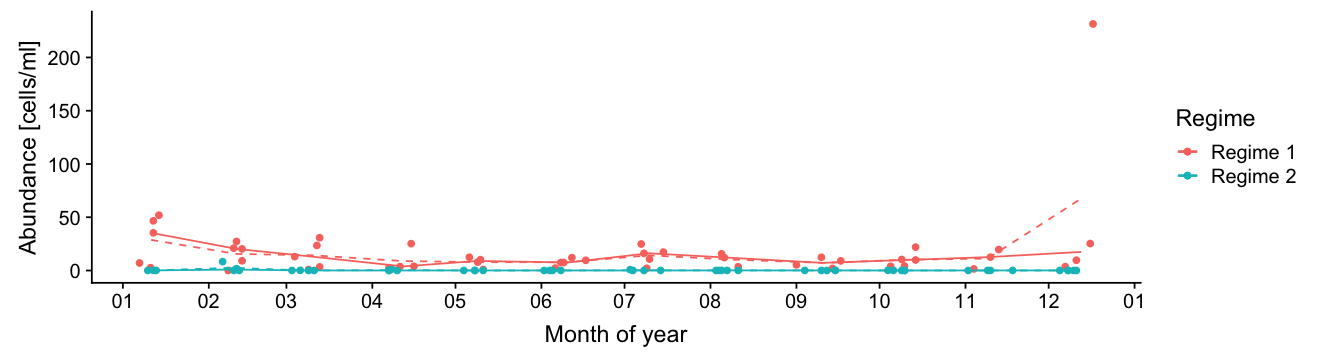

In [207]:
options(repr.plot.width=11, repr.plot.height=3)
ggplot() + geom_point(data=PGA_R1[PGA_R1$group == pf,],aes(x=dyear, y=value, col='Regime 1'))+ #scale_y_continuous(trans = 'reverse', limits = c(70,0), breaks=seq(70,0,-10))+
geom_point(data=PGA_R2[PGA_R2$group == pf,],aes(x=dyear, y=value, col='Regime 2')) +
geom_line(data=P1[P1$group == pf,],aes(x=dyear, y=mean, col='Regime 1'), linetype=2) +
geom_line(data=P2[P1$group == pf,],aes(x=dyear, y=mean, col='Regime 2'), linetype=2) +
geom_line(data=P1[P1$group == pf,],aes(x=dyear, y=median, col='Regime 1'), linetype=1) +
geom_line(data=P2[P1$group == pf,],aes(x=dyear, y=median, col='Regime 2'), , linetype=1) +
scale_x_date(date_breaks = 'months', labels = date_format('%m'))+
ylab('Abundance [cells/ml]') + xlab('Month of year') + labs(col='Regime')

# write N above MLD into csv

In [208]:
PGA_above_R1 <- data.frame(abundance = PGA_R1[PGA_R1$group == pf,]$value, month = PGA_R1[PGA_R1$group == pf,]$month, yday = PGA_R1yday)
PGA_above_R2 <- data.frame(abundance = PGA_R2[PGA_R2$group == pf,]$value, month = PGA_R2[PGA_R2$group == pf,]$month, yday = PGA_R2yday)

In [209]:
pf

[1] "DINOFLAGELLATES"

In [210]:
# Write CSV in R
write.csv(PGA_above_R1, file = paste("DATA_modelverification/",pf,"_above_R1.csv"))